In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
%matplotlib inline

In [5]:
from sklearn.datasets import load_boston

ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


In [7]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [8]:
data

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [14]:
bostonDF = pd.DataFrame(data, columns=["CRIM","ZN","INDUS","CHAS", "NOX","RM","AGE", "DIS","RAD","TAX","PTRATIO","B" ," LSTAT" ])

In [15]:
bostonDF["PRICE"] = target

In [17]:
bostonDF.shape

(506, 14)

In [18]:
bostonDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [28]:
y_target = bostonDF["PRICE"]
X_data = bostonDF.drop(["PRICE"], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

# 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷

### 규제 선형 모델의 개요
: 앞의 다항 회귀에서 Degree가 1인 경우는 지나치게 예측 곡선을 단순화해 데이터에 적합하지 않는 과소적합 모델이 만들어짐. <br>
<-> 반대로 Degree 15의 경우는 지나치게 모든 데이터에 적합한 회귀식을 만들기 위해서 다항식이 복잡해지고 회귀 계수가 매우 크게 설정이 되면서 평가 데이터 세트에 대해서 형편없는 예측 성능을 보임<br>
=> 따라서 회귀 모델은 적절히 데이터에 적합하면서도 회귀 계수가 기하급수적을 커지는 것을 제어할 수 있어야 함<br>

이전까지 선형 모델의 비용함수는 RSS를 최소화하는, 즉 실제 값과 예측값의 차이를 최소화하는 것만 고려
-> 학습 데이터에 지나치게 맞추게 되고, **회귀 계수가 쉽게 커짐**<br>
이럴 경우, 변동성이 오히려 심해져서 테스트 데이터 세트에서는 예측 성능이 저하되기 쉬움.<br>
이를 반영해 비용함수는 학습 데이터의 잔차 오류 값을 최소화하는 RSS 최소화 방법과 과적합을 방지하기 위해 회귀 계수 값이 커지지 않도록 하는 방법이 서로 균형을 이뤄야 함<br>

#### 비용 함수 목표 : Min(RSS(W)+alpha*||W||)<br>
- 비용함수의 목표는 (RSS(W)+alpha*||W||)를 최소화하는 W 벡터를 찾는 것

이때 alpha는 어떤 역할?<br>
- alpha : 학습 데이터 적합 정도와 회귀 계수 값의 크기 제어를 수행하는 튜닝 파라미터 <br>
: alpha값을 크게 하면 비용 함수는 회귀 계수 W의 값을 작게 해 과적합을 개선<br>
: alpha값을 작게 하면 회귀 계수 W의 값이 커져도 어느 정도 상쇄가 가능하므로 학습 데이터 적합을 더 개선할 수 있음 <br>
= alpha를 0에서부터 지속적으로 값을 증가시키면 회귀 계수 값의 크기를 감소시킬 수 있음 <br>

#### 규제(Regulation)
비용 함수에 alpha값으로 패널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식<br>
- L2방식<br>
: W의 제곱에 대해 패널티를 부여하는 방식 -> 릿지 회귀<br>
- L1방식 <br>
: W 절댓값에 대해 패널티를 부여 -> 라쏘 회귀 <br>
: L1 규제를 적용하면 영향력이 크지 않은 회귀 계수 값을 0으로 변환<br>

## 릿지 회귀 

: Ridge 클래스의 주요 생성 파라미터는 alpha이며, 이는 릿지 회귀의 alpha L2 규제 계수에 해당 


In [29]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# alpha=10 으로 설정해 릿지 회귀 수행
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print("5 folds의 개별 negative mse scores:", np.round(neg_mse_scores,3))
print("5 folds의 개별 RMSE scores:", np.round(rmse_scores,3))
print("5 folds의 평균 RMSE: {0:.3f}".format(avg_rmse) )

5 folds의 개별 negative mse scores: [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores: [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE: 5.518


In [30]:
# 릿지에 사용될 alpha 파라미터의 값을 정의
alphas = [0,0.1,1,10,100]

#alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함 
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    #cross_val_score를 이용해 5 폴드의 평균 rmse를 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    print("alpha {0}일 때 5 folds의 평균 RMSE : {1:.3f}".format(alpha, avg_rmse))

alpha 0일 때 5 folds의 평균 RMSE : 5.829
alpha 0.1일 때 5 folds의 평균 RMSE : 5.788
alpha 1일 때 5 folds의 평균 RMSE : 5.653
alpha 10일 때 5 folds의 평균 RMSE : 5.518
alpha 100일 때 5 folds의 평균 RMSE : 5.330


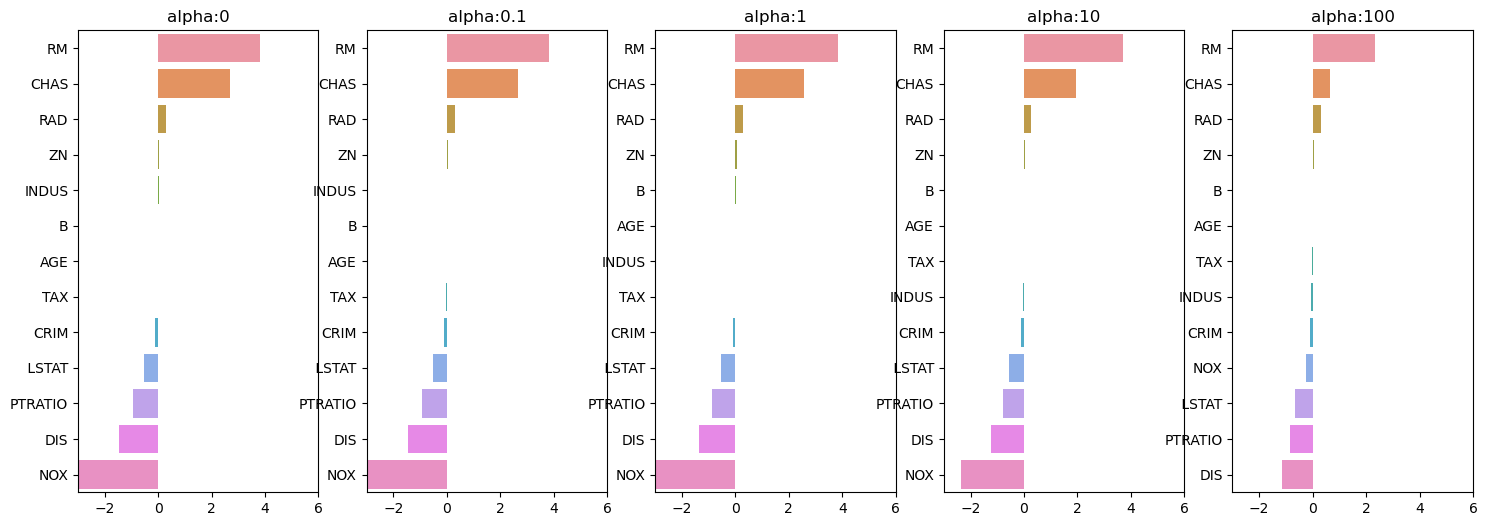

In [35]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig, axs = plt.subplots(figsize=(18,6), nrows=1, ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

#alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장, pos는 axis의 위치 저장
for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_data, y_target)
    #alpha에 따른 피처별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
    coeff = pd.Series(data=ridge.coef_,index=X_data.columns)
    colname= "alpha:"+str(alpha)
    coeff_df[colname]=coeff
    #막대그래프로 각 alpha 값에서의 회귀 계수를 시각화, 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])
    
plt.show()

In [36]:
ridge_alphas = [0,0.1,1,10,100]
sort_column = "alpha:"+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


> alpha 값 증가하면서, 회귀 계수 지속적으로 작아지고 있음. 
> 하지만 릿지 회귀의 경우에는 회귀 계수를 0으로 만들지는 않음

## 라쏘 회귀

: W의 절댓값에 패널티를 부여하는 L1 규제를 선형 회귀에 적용한 것이 라쏘 회귀<br>
-> 즉 L1 규제는 alpha* |W|를 의미하며, 라쏘 회귀 비용함수의 목표는 RSS(W)+alpha* |W| 식을 최소화하는 W를 찾는 것<br>
: L2 규제가 회귀 계수의 크기를 감소시키는 데 반해, L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거<br>
-> 이러한 측면에서 L1 규제는 적절한 피처만 회귀에 포함시키는 피처 선택의 특성을 가지고 있음<br>


In [37]:
from sklearn.linear_model import Lasso, ElasticNet

In [39]:
#alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환

def get_linear_reg_eval(model_name, params=None, X_data_n = None, y_target_n = None, verbose=True):
    coeff_df = pd.DataFrame()
    if verbose: print("#####", model_name, "####")
    for param in params:
        if model_name == "Ridge": model = Ridge(alpha=param)
        elif model_name == "Lasso": model = Lasso(alpha=param)
        elif model_name == "ElasticNet": model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n,
                                        scoring="neg_mean_squared_error",cv=5)
        avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
        print("alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f}".format(param, avg_rmse))
        #cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        model.fit(X_data, y_target)
        #alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
        coeff = pd.Series(data=model.coef_, index=X_data.columns)
        colname = "alpha:"+str(param)
        coeff_df[colname]=coeff
    return coeff_df

In [42]:
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]

coeff_lasso_df = get_linear_reg_eval("Lasso", params=lasso_alphas, X_data_n = X_data, y_target_n = y_target)

##### Lasso ####
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189


In [44]:
#반환된 coeff_lasso_df를 첫번째 칼럼 순으로 내림차순 정렬해 회귀 계수 DataFrame 출력

sort_column = "alpha:"+str(lasso_alphas[0])

coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


## 엘라스틱넷 회귀

라쏘 회귀가 서로 상관관계가 높은 피처들의 경우에 이들 중에서 중요 피처만을 셀렉션하고 다른 피처들은 모두 회귀 계수를 0으로 만드는 성향이 강함 <br>
-> 특히 이러한 성향으로 인해 alpha값에 따라 회귀 계수의 값이 급격히 변동할 수도 있는데, 엘라스틱넷 회귀는 이를 완화하기 위해 L2 규제를 라쏘 회귀에 추가 <br>

ElasticNet 클래스의 alpha는 Ridge와 Lasso 클래스의 alpha값과는 다름<br>
엘라스틱넷의 규제는 a*L1 + b*L2로 정의될 수 있으며, 이 때 a는 L1 규제의 alpha값, b는 L2의 규제값<br>
-> ElasticNet 클래스의 alpha 파라미터 값은 a+b <br>
ElasticNet 클래스의 l1_ratio 파라미터 값은 a / (a+b)<br>
-> l1_ratio 0이면 L2 규제와 동일 / 1이면 L1 규제와 동일<br>

In [45]:
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]

coeff_elastic_df = get_linear_reg_eval("ElasticNet", params=elastic_alphas, X_data_n = X_data, y_target_n = y_target)

##### ElasticNet ####
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068


In [47]:
#반환된 coeff_lasso_df를 첫번째 칼럼 순으로 내림차순 정렬해 회귀 계수 DataFrame 출력

sort_column = "alpha:"+str(elastic_alphas[0])

coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


> alpha값에 따른 피처들의 회귀 계수들 값이 라쏘보다는 상대적으로 0이 되는 값이 적음을 알 수 있음

## 선형 회귀 모델을 위한 데이터 변환


- 선형 회귀 모델과 같은 선형 모델은 일반적으로 피처와 타깃값 간에 선형의 관계가 있다고 가정, 이러한 최적의 선형함수를 찾아내 결과값을 예측
- 선형 회귀 모델은 피처값과 타깃값의 분포가 정규 분포 (즉 평균을 중심으로 종 모양으로 데이터 값이 분포된 형태) 형태를 매우 선호 
- 특히 타깃값의 경우 정규 분포 형태가 아니라 특정값의 분포가 치우친 왜곡된 형태의 분포도일 경우 예측 성능에 부정적인 영향을 미칠 가능성이 높음. 피처값 역시 결정값보다는 덜하지만 왜곡된 분포도로 인해 예측에 부정적인 영향을 미칠 수 있음

**=> 따라서 선형 회귀 모델을 적용하기 전에 먼저 데이터에 대한 스케일링/정규화 작업을 수행하는 것이 일반적**


- 피처 데이터 세트에 적용하는 변환 작업
1. Standard Scaler ; 평균0, 분산1_표준 정규 분포를 가진 데이터 세트로 변환 / MinMaxScaler
2. 스케일링/정규화를 수행한 데이터 세트에 다시 다항 특성을 적용하여 변환하는 방법 <br>
    (보통 1번 방법을 통해 예측 성능에 향상이 없을 경우 이와 같은 방법 적용)
3. Log Transformation; 원래 값에 log 함수를 적용하면 보다 정규 분포에 가까운 형태로 값이 분포 <br>

: 1번 방법의 경우 예측 성능 향상을 크게 기대하기 어려운 경우가 많으며, 2번 방법의 경우 피처의 개수가 매우 많을 경우에는 다항 변환으로 생성되는 피처의 개수가 기하급수로 늘어나서 과적합의 이슈가 발생할 수 있기 때문. 그래서 3번이 가장 많이 사용

- 타깃값의 경우는 일반적으로 로그 변환 적용 <br>
: 결정 값을 정규 분포나 다른 정규값으로 변환하면 변환된 값을 다시 원본 타깃값으로 원복하기 어려울 수 있음. 무엇보다도, 왜곡된 분포도 형태의 타깃값을 로그 변환하여 예측 성능 향상이 된 경우가 많은 사례에서 검증되었기 때문에 타깃값의 경우는 로그 변환을 적용

In [53]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

In [56]:
def get_scaled_data(method="None",p_degree=None, input_data=None):
    if method == "Standard":
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == "MinMax":
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == "Log":
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)
    
    return scaled_data

In [57]:
alphas = [0.1, 1, 10, 100]

scale_methods =[(None,None), ("Standard",None), ("Standard",2),
               ("MinMax",None),("MinMax",2),("Log",None)]


for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1],
                                   input_data=X_data)
    
    print("\n## 변환유형: {0}, Polynomial Degree:{1}".format(scale_method[0],scale_method[1]))
    get_linear_reg_eval("Ridge", params=alphas, X_data_n=X_data_scaled, y_target_n=y_target, verbose=False)


## 변환유형: None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330

## 변환유형: Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421

## 변환유형: Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.485
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634

## 변환유형: MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.764
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.465
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.754
alpha 100일 때 5 폴드 세트의 평균 RMSE: 7.635

## 변환유형: MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.298
alpha 1일 때 5 폴드 세트의 평균 RMSE: 4.323
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.185
alpha 100일 때 5 폴드 세트의 평균 RMSE: 6.538

## 변환유형: Log, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 4.770

# 로지스틱 회귀 

로지스틱 회귀는 선형 회귀 방식을 분류에 적용한 알고리즘 <br>
= 로지스틱 회귀는 분류에 사용, 로지스틱 회귀 역시 선형 휘귀 계열

회귀가 선형인가 비선형인가는 독립변수가 아닌 가중치 변수가 선형인지 아닌지를 따름

로지스틱 회귀가 선형회귀와 다른 점은 학습을 통해 선형 함수의 회귀 최적선을 찾는 것이 아니라 **시그모이드 함수 최적선을 찾고, 이 시그모이드 함수의 반환값을 확률로 간주해 확률에 따라 분류를 결정**

**시그모이드 함수**<br>
: 많은 자연, 사회 현상에서 특정 변수의 확률 값은 선형이 아니라 시그모이드 함수와 같이 S자 커브 형태를 가짐<br>
: 시그모이드 함수의 정의는 y = 1/(1+e^(-x))<br>
: x값이 +, -로 아무리 커지거나 작아져도 y값은 항상 0과 1사이 값을 반환<br>
(x값이 커지면 1에 근사하며, 작아지면 0에 근사. 그리고 x가 0이면 0.5)

ex. 종양의 크기에 따라 악성 종양인지 그렇지 않은지 회귀를 이용해 1과 0의 값으로 예측하는 것<br>
종양크기에 따라 악성이 될 확률이 높다고 한다면 종양 크기를 x축, 악성 종양 여부를 y축에 표시<br>
; 회귀를 적용하면 데이터가 모여 있는 곳으로 선형 회귀 선을 그릴 수 있지만 제대로 분류 못하고 있음 <br>
하지만 s자 커브 형태의 시그모이드 함수를 이용하면 좀 더 정확하게 0과 1에 대해 분류를 할 수 있음<br>

=> 로지스틱 회귀는 선형 회귀 방식을 기반으로 하되 시그모이드 함수를 이용해 분류를 수행하는 회귀 

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#StandardScaler()로 평균이 0, 분산1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

In [21]:
from sklearn.metrics import accuracy_score, roc_auc_score

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

#정확도와 roc_auc 측정
print("accuracy: {:0.3f}".format(accuracy_score(y_test, lr_preds)))
print("roc_auc: {:0.3f}".format(roc_auc_score(y_test, lr_preds)))

accuracy: 0.977
roc_auc: 0.972


사이킷런 LogisticRegression 클래스의 주요 하이퍼 파라미터로 penalty와 C <br>
penalty는 규제(regulation)의 유형을 설정하며 "l2" -> L2 규제를, "l1" -> L1 규제를 뜻함<br>
C는 규제  강도를 조절하는 alpha값의 역수 ; C값이 작을수록 규제 강도가  큼<br>

In [23]:
from sklearn.model_selection import GridSearchCV

params = {"penalty": ["l2"],
         "C": [0.01, 0.1, 1, 5, 10]}

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring="accuracy", cv=3)

grid_clf.fit(data_scaled, cancer.target)

print("최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}".format(grid_clf.best_params_, grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 1, 'penalty': 'l2'}, 최적 평균 정확도:0.975


In [27]:
from sklearn.model_selection import GridSearchCV

params = {"penalty": ["l1"],
          "solver" : ["liblinear"],
         "C": [0.01, 0.1, 1, 5, 10]}

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring="accuracy", cv=3)

grid_clf.fit(data_scaled, cancer.target)

print("최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}".format(grid_clf.best_params_, grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 5, 'penalty': 'l1', 'solver': 'liblinear'}, 최적 평균 정확도:0.967
